In [1]:
import numpy as np 
import pandas as pd
import math
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import os

In [4]:
#import the data, it is saved in the same directory as the notebook as a CSV 
path = os.getcwd()
#import the data, it is saved in the same directory as the notebook as a CSV 
path = os.getcwd()
data = pd.read_csv(path + '/GBOND20010731.csv')

In [10]:
#import the data, it is saved in the same directory as the notebook as a CSV 
path = os.getcwd()
data = pd.read_csv(path + '/GBOND20010731.csv')

#separating only yield rates and maturities
yields = list(data['YTM'].values)
#converting maturity to years
maturities = list((data['TAU']/365).values)

#print first 5 elements of each list to show
print(yields[:5])
print(maturities[:5])

[5.1, 5.03, 5.1, 5.05, 5.1]
[0.26301369863013696, 0.26301369863013696, 0.26301369863013696, 0.26301369863013696, 0.43561643835616437]


In [11]:
#Nelson-Siegel discount function
def NS(B0, B1, B2, tau, m):
    return B0 + (B1+B2)*(1-math.exp(-m/tau))*(tau/m) - B2*math.exp(-m/tau)

#NS_forward is the function to calculate the forward rate using the same parameters
def NS_forward(B0, B1, B2, tau, m):
    return B0 + B1*math.exp(-m/tau) + B2*(m/tau)*math.exp(-m/tau)

#create two function X1 and X2 that are partof the 2nd and 3rd term of the NS equation, respectively
#we use these to create X inputs for a linear regression
def X1(tau, m):
    return (1-math.exp(-m/tau))*(tau/m)

def X2(tau, m):
    return math.exp(-m/tau)

In [12]:
tau = 0
curmin = 99
for i in np.linspace(0.01, 30, 500):
    x1 = []
    x2 = []
    for j in range(len(yields)):
        x1.append(X1(i, maturities[j]))
        x2.append(X2(i, maturities[j]))
    df = pd.DataFrame({"A": yields, "B":x1, "C":x2})
    result = sm.ols(formula = 'A ~ B + C', data=df).fit()
    r = sum(result.resid**2)
    if r < curmin:
        curmin = r
        tau = i

tau

4.577615230460921

In [14]:
#using this value of tau we can now estimate our parameters for B0, B1, and B2

x1 = []
x2 = []
for j in range(len(yields)):
    x1.append(X1(tau, maturities[j]))
    x2.append(X2(tau, maturities[j]))
df = pd.DataFrame({"A": yields, "B":x1, "C":x2})
result = sm.ols(formula = 'A ~ B + C', data=df).fit()
B0, B1, B2 = result.params[0], result.params[1] - result.params[2], result.params[2]

print(B0, B1, B2, tau)

8.034548281030878 -3.019012794296195 0.009084637640675908 4.577615230460921


In [19]:
#now construct a dataframe of the calculated spot and forward rates from maturity 0 to 10 years
NS_forward_yields = []
NS_yield = []
forward = 0
ytm = 0
result_dict = {}
plot_maturities = np.linspace(0.001, 10, 100)
for m in plot_maturities:
    forward = (NS_forward(B0, B1, B2, tau, m))
    ytm = (NS(B0,B1,B2, tau, m))
    result_dict[m] = [forward, ytm]

df = pd.DataFrame.from_dict(result_dict, orient = 'index')
df.columns = ['Forward Rate','Spot Rate']
df.index.name = 'Maturity (Years)'
df.head(5)

,Forward Rate,Spot Rate
Maturity (Years),,
0.001,5.016197,5.015866
0.102,5.082260,5.049022
0.203,5.146878,5.081693
0.304,5.210081,5.113888
0.405,5.271900,5.145613


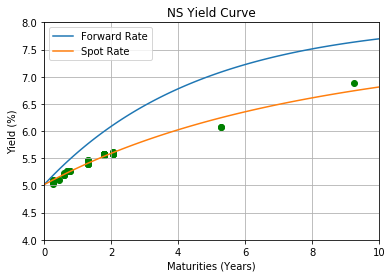

In [20]:
forward_rates = plt.plot(df['Forward Rate'])
spot_rates = plt.plot(df['Spot Rate'])
actual_yields = plt.scatter(maturities, yields, color = 'g')
plt.title('NS Yield Curve')
plt.xlabel('Maturities (Years)')
plt.ylabel('Yield (%)')
plt.grid()
plt.legend()
plt.axis(xmin = 0, ymin = 4, xmax = 10, ymax = 8)
plt.legend()
plt.show()